In [20]:
pip install catboost shap

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay

from catboost import CatBoostClassifier
from google.colab import drive
from collections import Counter
from joblib import dump, load

In [10]:
drive.mount('/content/drive/')

Mounted at /content/drive/


For CatBoost, we are going to perform a randomized search, due to hardware and time limitations. First, we are going to prepare the data by loading it and converting the categorical features to string, so that the model doesn't  confuse them as numerical

In [31]:
X_train = pd.read_csv("/content/drive/MyDrive/road_accidents/X_train_new.csv", index_col = 0)
y_train = pd.read_csv("/content/drive/MyDrive/road_accidents/y_train_new.csv", index_col = 0)

X_test = pd.read_csv("/content/drive/MyDrive/road_accidents/X_test_new.csv", index_col = 0)
y_test = pd.read_csv("/content/drive/MyDrive/road_accidents/y_test_new.csv", index_col = 0)

In [13]:
categorical_features = ["day_of_week", "first_road_class", "road_type", "junction_detail",
                   "second_road_class", "pedestrian_crossing_human_control",
                   "pedestrian_crossing_physical_facilities", "light_conditions", "weather_conditions",
                   "road_surface_conditions", "special_conditions_at_site", "carriageway_hazards",
                   "did_police_officer_attend_scene_of_accident", "vehicle_type", "towing_and_articulation",
                   "vehicle_manoeuvre", "vehicle_location_restricted_lane", "junction_location",
                   "skidding_and_overturning", "hit_object_in_carriageway", "hit_object_off_carriageway",
                   "vehicle_leaving_carriageway", "first_point_of_impact", "sex_of_driver", "vehicle_left_hand_drive",
                   "journey_purpose_of_driver", "casualty_class", "sex_of_casualty",
                   "pedestrian_location", "pedestrian_movement", "car_passenger", "bus_or_coach_passenger",
                   "pedestrian_road_maintenance_worker", "vehicle_direction_from", "vehicle_direction_to",
                   "age_band_of_casualty", "day_of_month", "month", "time_rounded",]

In [6]:
for col in categorical_features:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)

Now, we're going to compute the class weights due to the high class imbalance

In [7]:
class_counts = Counter(y_train["accident_severity"])
total_samples = sum(class_counts.values())
class_weights_dict = {cls: total_samples / count for cls, count in class_counts.items()}
class_weights = list(class_weights_dict.values())
class_weights.reverse()
class_weights

[47.34840481724065, 4.480745391290439, 1.3232715098049637]

Here are the hyperparameters we would like to explore:

In [12]:
param_distributions = {
    'iterations': [500, 1000, 3000, 8000],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.05, 0.2],
    'l2_leaf_reg': [1, 7],
    'class_weights': [class_weights, None]
}

In [9]:
catboost_model = CatBoostClassifier(
    random_seed=42,
    task_type="GPU",
    devices='0:2',
    max_bin = 128,
    early_stopping_rounds = 100
)

In [10]:
random_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_distributions,
    n_iter=40,
    scoring='f1_weighted',
    cv=3,
    random_state=42,
    verbose=3,
)


In [11]:
random_search.fit(X_train, y_train)

Streaming output truncated to the last 5000 lines.
6007:	learn: 0.5080262	total: 19.8s	remaining: 6.58s
6008:	learn: 0.5079997	total: 19.9s	remaining: 6.58s
6009:	learn: 0.5079695	total: 19.9s	remaining: 6.57s
6010:	learn: 0.5079392	total: 19.9s	remaining: 6.57s
6011:	learn: 0.5079212	total: 19.9s	remaining: 6.57s
6012:	learn: 0.5079138	total: 19.9s	remaining: 6.56s
6013:	learn: 0.5078915	total: 19.9s	remaining: 6.56s
6014:	learn: 0.5078757	total: 19.9s	remaining: 6.56s
6015:	learn: 0.5078608	total: 19.9s	remaining: 6.55s
6016:	learn: 0.5078199	total: 19.9s	remaining: 6.55s
6017:	learn: 0.5078104	total: 19.9s	remaining: 6.55s
6018:	learn: 0.5077955	total: 19.9s	remaining: 6.54s
6019:	learn: 0.5077707	total: 19.9s	remaining: 6.54s
6020:	learn: 0.5077582	total: 19.9s	remaining: 6.54s
6021:	learn: 0.5077319	total: 19.9s	remaining: 6.53s
6022:	learn: 0.5077080	total: 19.9s	remaining: 6.53s
6023:	learn: 0.5076890	total: 19.9s	remaining: 6.53s
6024:	learn: 0.5076730	total: 19.9s	remaining: 6

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/catboost/core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/usr/local/lib/python3.10/dist-packages/catboost/core.py", line 2395, in _f

Streaming output truncated to the last 5000 lines.
3000:	learn: 0.2275323	total: 29.9s	remaining: 49.7s
3001:	learn: 0.2274945	total: 29.9s	remaining: 49.7s
3002:	learn: 0.2274739	total: 29.9s	remaining: 49.7s
3003:	learn: 0.2274361	total: 29.9s	remaining: 49.7s
3004:	learn: 0.2273697	total: 29.9s	remaining: 49.7s
3005:	learn: 0.2273126	total: 29.9s	remaining: 49.7s
3006:	learn: 0.2272717	total: 29.9s	remaining: 49.7s
3007:	learn: 0.2272403	total: 29.9s	remaining: 49.7s
3008:	learn: 0.2272096	total: 29.9s	remaining: 49.6s
3009:	learn: 0.2271710	total: 29.9s	remaining: 49.6s
3010:	learn: 0.2271361	total: 29.9s	remaining: 49.6s
3011:	learn: 0.2270719	total: 30s	remaining: 49.6s
3012:	learn: 0.2270333	total: 30s	remaining: 49.6s
3013:	learn: 0.2269880	total: 30s	remaining: 49.6s
3014:	learn: 0.2269365	total: 30s	remaining: 49.6s
3015:	learn: 0.2269045	total: 30s	remaining: 49.6s
3016:	learn: 0.2268802	total: 30s	remaining: 49.6s
3017:	learn: 0.2268599	total: 30s	remaining: 49.6s
3018:	lea

RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7c9c30c96410>,
                   n_iter=40,
                   param_distributions={'class_weights': [[47.34840481724065,
                                                           4.480745391290439,
                                                           1.3232715098049637],
                                                          None],
                                        'depth': [4, 6, 8, 10],
                                        'iterations': [500, 1000, 3000, 8000],
                                        'l2_leaf_reg': [1, 7],
                                        'learning_rate': [0.05, 0.2]},
                   random_state=42, scoring='f1_weighted', verbose=3)

In [14]:
print("Best Parameters:", random_search.best_params_)

# Best score
print("Best Score:", random_search.best_score_)

# Best model
best_catboost_model = random_search.best_estimator_

Best Parameters: {'learning_rate': 0.2, 'l2_leaf_reg': 1, 'iterations': 8000, 'depth': 8, 'class_weights': [47.34840481724065, 4.480745391290439, 1.3232715098049637]}
Best Score: 0.777587036382279


In [19]:
best_catboost_model.score(X_train, y_train)

0.9815595716198126

In [15]:
best_catboost_model.score(X_test, y_test)

0.7918875502008033

In [17]:
y_pred = best_catboost_model.predict(X_test)

In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.81      0.43      0.56      2367
           2       0.54      0.56      0.55     25007
           3       0.87      0.87      0.87     84676

    accuracy                           0.79    112050
   macro avg       0.74      0.62      0.66    112050
weighted avg       0.79      0.79      0.79    112050



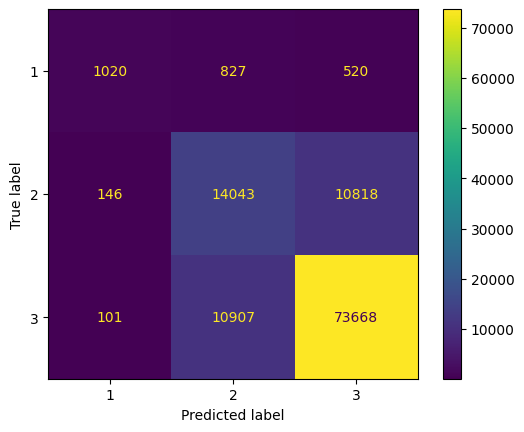

In [20]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [21]:
best_catboost_model.save_model("/content/drive/MyDrive/road_accidents/best_catboost_model_randomized_search.cbm")

Now that we have a good CatBoost model, let's try to interpret its features

In [18]:
best_catboost_model = CatBoostClassifier()
best_catboost_model.load_model("/content/drive/MyDrive/road_accidents/best_catboost_model_randomized_search.cbm")

In [19]:
best_catboost_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,day_of_month,6.819671
1,engine_capacity_cc,6.202791
2,time_rounded,5.778921
3,month,5.450159
4,age_of_driver,5.282946
5,age_of_vehicle,5.139190
6,day_of_week,4.475835
7,accident_year,4.052992
8,vehicle_direction_from,3.974631
9,vehicle_manoeuvre,3.965975


It's interesting, that the most important feature, according to CatBoost is the day of the month. We will have to take a deep look at it further in the analysis. The features after it seem to be not that surprising, when it comes to predicting severity.